In [1]:
import cv2
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import tensorflow as tf

from skimage import transform
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model

In [2]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [3]:
image_size = (224, 224)
input_shape = image_size + (3,)
num_classes = 5
batch_size = 32
data_dir = "datasets/"

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  validation_split=0.3,
  subset="training",
  label_mode="categorical",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  validation_split=0.3,
  subset="validation",
  label_mode="categorical",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

Found 1030 files belonging to 5 classes.
Using 721 files for training.
Found 1030 files belonging to 5 classes.
Using 309 files for validation.


In [5]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

print(f"Using : {len(np.concatenate([i for x, i in test_ds], axis=0))} files for testing")

Using : 192 files for testing


Found 1030 files belonging to 5 classes.


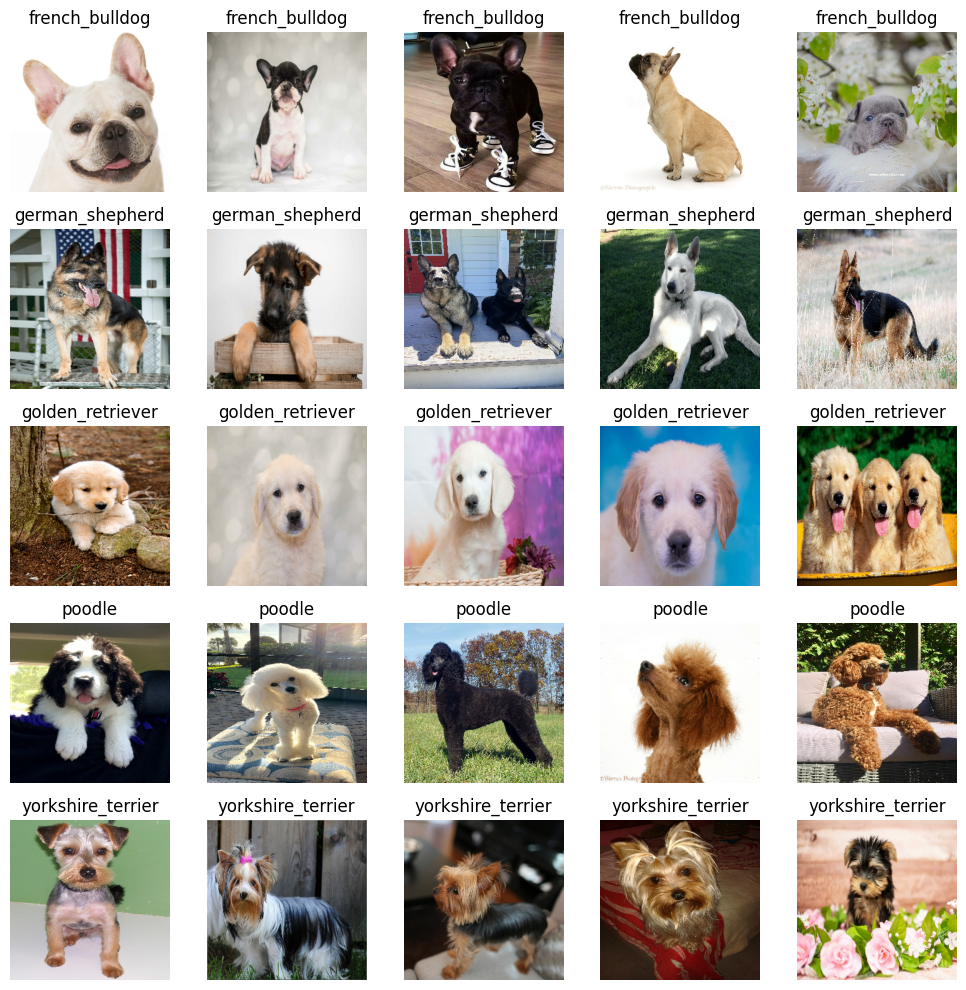

In [6]:
data_temp = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=5,
    shuffle=False,
    seed=123,
)

class_names = data_temp.class_names

fig, axes = plt.subplots(5, 5, figsize=(10,10))
axes = axes.flatten()

for i, cls in enumerate(class_names):
    j = 0
    
    for img, label in data_temp:
        if label[0] == i:
            ax = axes[i*5 + j]
            ax.imshow(img[0].numpy().astype("uint8"))
            ax.set_title(cls)
            ax.axis('off')
            j += 1
            if j == 5:
                break
                
plt.tight_layout()
plt.show()


In [7]:
inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Lambda(preprocess_input)(inputs)

resnet_model = ResNet50(weights='imagenet', 
                        include_top=False, 
                        input_shape=input_shape,
                        input_tensor=x)

for layer in resnet_model.layers:
    layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(resnet_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=predictions)

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

In [9]:
checkpoint_path = "models/best_resnet.h5"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

In [10]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[model_checkpoint, early_stopping])

Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 0.5303 - accuracy: 0.8225
Epoch 1: val_accuracy improved from -inf to 0.94872, saving model to models\best_resnet.h5
23/23 [==============================] - 16s 278ms/step - loss: 0.5303 - accuracy: 0.8225 - val_loss: 0.0719 - val_accuracy: 0.9487
Epoch 2/10
22/23 [===========================>..] - ETA: 0s - loss: 0.0815 - accuracy: 0.9744
Epoch 2: val_accuracy improved from 0.94872 to 0.99145, saving model to models\best_resnet.h5
23/23 [==============================] - 7s 254ms/step - loss: 0.0800 - accuracy: 0.9750 - val_loss: 0.0210 - val_accuracy: 0.9915
Epoch 3/10
22/23 [===========================>..] - ETA: 0s - loss: 0.0458 - accuracy: 0.9830
Epoch 3: val_accuracy did not improve from 0.99145
23/23 [==============================] - 7s 230ms/step - loss: 0.0477 - accuracy: 0.9820 - val_loss: 0.0345 - val_accuracy: 0.9829
Epoch 4/10
22/23 [===========================>..] - ETA: 0s - loss: 0.0271 - accuracy: 0

In [12]:
history_df = pd.DataFrame(history.history)
history_df.to_csv("history/history_resnet.csv", index=False)

In [13]:
best_model = tf.keras.models.load_model("models/best_resnet.h5")

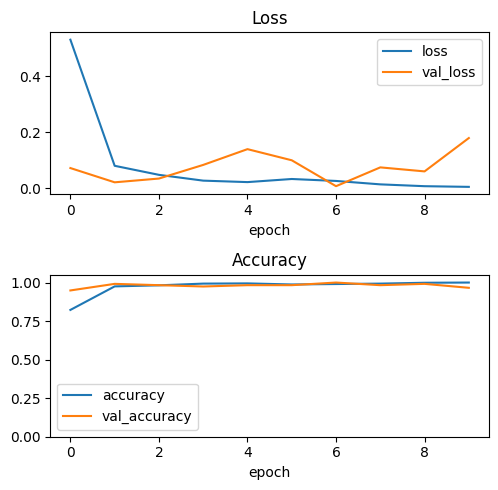

In [14]:
history = pd.read_csv("history/history_resnet.csv")

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(211)
ax1.set_title('Loss')
ax1.plot(history['loss'], label='loss')
ax1.plot(history['val_loss'], label='val_loss')
ax1.set_xlabel("epoch")
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.set_title('Accuracy')
ax2.plot(history['accuracy'], label='accuracy')
ax2.plot(history['val_accuracy'], label='val_accuracy')
ax2.set_xlabel("epoch")
ax2.legend()
ax2.set_ylim(0, 1.05) 

plt.tight_layout()
plt.show()

In [15]:
y_test_pred = []
y_test_true = []

for x, y in test_ds:
    y_test_pred.append(np.argmax(best_model(x), axis=-1))
    y_test_true.append(y.numpy())

y_test_pred = np.concatenate(y_test_pred, axis=0)
y_test_true = np.concatenate(y_test_true, axis=0)
y_test_true = np.argmax(y_test_true, axis=1)

print(classification_report(y_test_true, y_test_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9762    0.9880        42
           1     0.9787    1.0000    0.9892        46
           2     1.0000    1.0000    1.0000        49
           3     0.9667    1.0000    0.9831        29
           4     1.0000    0.9615    0.9804        26

    accuracy                         0.9896       192
   macro avg     0.9891    0.9875    0.9881       192
weighted avg     0.9899    0.9896    0.9896       192



In [16]:
print(confusion_matrix(y_test_true, y_test_pred))

[[41  1  0  0  0]
 [ 0 46  0  0  0]
 [ 0  0 49  0  0]
 [ 0  0  0 29  0]
 [ 0  0  0  1 25]]


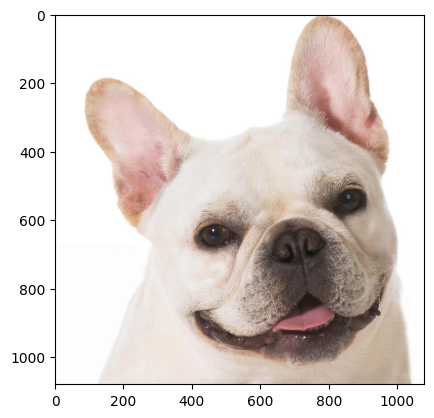

In [17]:
img = cv2.imread("datasets/french_bulldog/0200259a-2722-4576-86fb-6ead7393d8a0.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [19]:
def predict_image(img, probs=True):
    img = img.astype('float32')
    img = tf.image.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)
    prediction = best_model.predict(img)[0]
    class_probs = {class_names[i]: float(prediction[i]) for i in range(5)}
    predicted_class = max(class_probs, key=class_probs.get)
    
    if probs == True:
        return class_probs
    else:
        return predicted_class

In [21]:
predict_new = predict_image(img, probs=False)

print("Actual : french_bulldog")
print(f"Predicted : {predict_new}")


1/1 [==============================] - 0s 17ms/step
Actual : french_bulldog
Predicted : french_bulldog


In [22]:
interface = gr.Interface(
    fn=predict_image, 
    inputs=gr.Image(shape=(224,224)),
    outputs=gr.Label(num_top_classes=5))

interface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 19ms/step
